In [1]:
import torch
import matplotlib.pyplot as plt
from time import time

In [2]:
from gromov_wasserstein import Entropic_GromovWasserstein as Entropic_GW

In [125]:
def show_P(P, filename, savefig=False):
    fig, ax = plt.subplots(1, 2)

    ax[0].imshow(P)
    ax[0].set_title('P')

    max_P, idx = torch.max(P, dim=1, keepdim=True)
    X = (P>=max_P).int() #* 10

    ax[1].imshow(X)
    ax[1].set_title('argmax rows of P')
    
    if savefig:
        fig.savefig(filename)

## eps needs not be too small compare to cost matrix's elements (C)

If we use stabilized_entropic_wasserstein (stable_sinkhorn=True), we can use small values for eps, but it takes longer time to converge. Therefore, we need to set w_max_iter to larger nubmer.
=> Generally, the running time is longer (slower).
\
But we can use smaller eps => receive closer to ground-truth transport plan P, better approximation gw_cost for the gromov-wasserstein distance.
\
\
If using original entropic wasserstein (stable_sinkhorn=False), we need to use relatively large values for eps, the original wasserstein's codes run faster than the stable version, and we can set w_max_iter to small number (even 1 iter is okie, check 7.4 of Gromov-Wasserstein Learning for Graph Matching and Node Embedding).
\
However, we have to use relatively large eps => the learned plan P will be denser, and less accurate approximation gw_cost.

### Ex0: Simple rotation

In [116]:
# randomly create point clouds x, y
# y is just a translated cloud from x

PI = torch.tensor(torch.acos(torch.zeros(1)).item() * 2)
theta = PI * 1/2
rotation = torch.tensor([[torch.cos(theta), -torch.sin(theta)], 
                         [torch.sin(theta), torch.cos(theta)]])

#x = torch.randn((500, 2)) + 10
x = torch.tensor([[0., 0.], [0., 2.], [1., 0.], [1., 1.]])

n = 15
x = torch.tensor([[i, 0*i + 1] for i in range(n)]).float()
#y = x.clone() + 5
y = x @ rotation.T + 5

#noise = torch.randn(y.shape) * 2

px = torch.ones(x.shape[0])
px /= px.sum()

py = torch.ones(y.shape[0])
py /= py.sum()

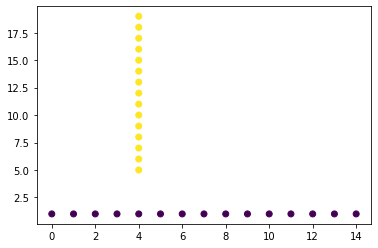

In [124]:
# visualize the points in 2D

points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

plt.savefig('simple_rotation_points.png')

In [118]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

x = x.to(device)
y = y.to(device)
px = px.to(device)
py = py.to(device)

cpu


Iter: 0 | Err = 0.156288
Break in Sinkhorn alg at 1-th iteration: Err = 0.000000
Iter: 10 | Err = 0.000805
Break in Sinkhorn alg at 1-th iteration: Err = 0.000000
Break in Gromov-Wasserstein at 11-th iteration: Err = 0.000000
Computed in 3.1617 s
gw_cost: 0.00000


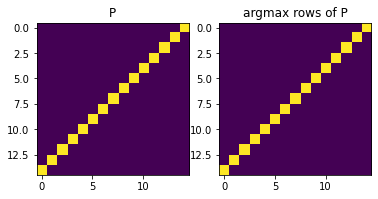

In [127]:
# stable version
gw_dist = Entropic_GW(eps=1e-1, max_iter=100, thresh=1e-5, 
                      w_max_iter=1000, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=True, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'), 'simple_rotation_P_stable.png', True)

Iter: 0 | Err = 0.117160
Iter: 10 | Err = 0.050784
Break in Gromov-Wasserstein at 17-th iteration: Err = 0.000003
Computed in 0.0271 s
gw_cost: 51.97699


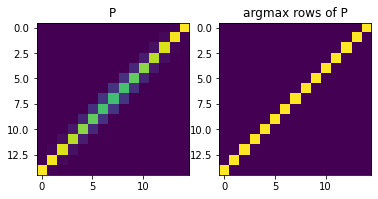

In [128]:
# original wasserstein
# eps = 1e3, max_iter = 1
gw_dist = Entropic_GW(eps=1e2, max_iter=100, thresh=1e-5, 
                      w_max_iter=10, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=False, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'), 'simple_rotation_P_unstable.png', True)

### Ex1: Simple translation

In [4]:
# randomly create point clouds x, y
# y is just a translated cloud from x

x = torch.randn((50, 2)) * 10
y = x.clone() + 100

x = torch.tensor([[0, 0], [0, 2], [1, 0], [1, 1]]).float()
y = x.clone() + 5

n = 20
x = torch.tensor([[i, 0*i + 1] for i in range(n)]).float()
y = x.clone() + n

#noise = torch.randn(y.shape) * 2

px = torch.ones(x.shape[0])
px /= px.sum()

py = torch.ones(y.shape[0])
py /= py.sum()

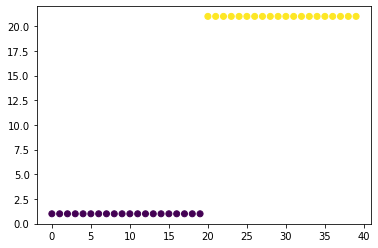

In [5]:
# visualize the points in 2D

points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

x = x.to(device)
y = y.to(device)
px = px.to(device)
py = py.to(device)

cuda:0


Iter: 0 | Err = 0.133750
Break in Sinkhorn alg at 1-th iteration: Err = 0.000000
Break in Sinkhorn alg at 1-th iteration: Err = 0.000000
Break in Gromov-Wasserstein at 9-th iteration: Err = 0.000000
Computed in 2.9462 s
gw_cost: 0.00000


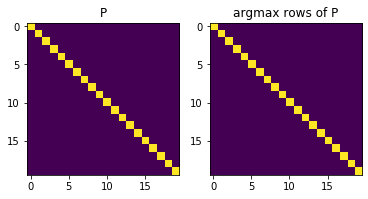

In [7]:
# stable version
# eps = 1e0 => w_max_iter is large
gw_dist = Entropic_GW(eps=1e0, max_iter=100, thresh=1e-5, 
                      w_max_iter=500, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=True, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

Iter: 0 | Err = 0.130958
Iter: 10 | Err = 0.200735
Break in Gromov-Wasserstein at 17-th iteration: Err = 0.000001
Computed in 0.0244 s
gw_cost: 24.04648


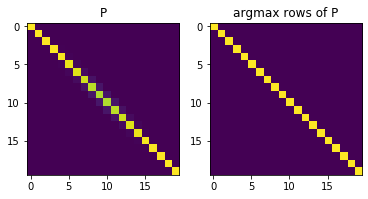

In [8]:
# stable version
# eps = 1e2, w_max_iter = 1 
gw_dist = Entropic_GW(eps=1e2, max_iter=100, thresh=1e-5, 
                      w_max_iter=1, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=True, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

Iter: 0 | Err = 0.100426
Iter: 10 | Err = 0.009123
Iter: 20 | Err = 0.007239
Iter: 30 | Err = 0.000091
Break in Gromov-Wasserstein at 36-th iteration: Err = 0.000007
Computed in 0.0278 s
gw_cost: 698.69643


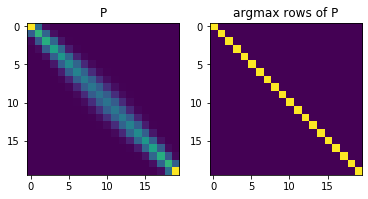

In [9]:
# original wasserstein
# eps = 1e3, max_iter = 1
gw_dist = Entropic_GW(eps=1e3, max_iter=100, thresh=1e-5, 
                      w_max_iter=1, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=False, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

### Ex2: Simple translation of a point cloud

In [10]:
# randomly create point clouds x, y
# y is just a translated cloud from x

x = torch.randn((100, 2)) * 10
y = x.clone() + 100

#noise = torch.randn(y.shape) * 2

px = torch.ones(x.shape[0])
px /= px.sum()

py = torch.ones(y.shape[0])
py /= py.sum()

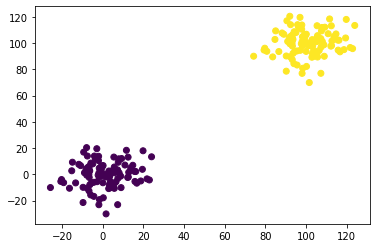

In [11]:
# visualize the points in 2D

points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

In [12]:
x = x.double().to(device)
y = y.double().to(device)
px = px.double().to(device)
py = py.double().to(device)

print(device)

cuda:0


Iter: 0 | Err = 0.058588
Break in Gromov-Wasserstein at 6-th iteration: Err = 0.000000
Computed in 47.9549 s
gw_cost: 0.12883


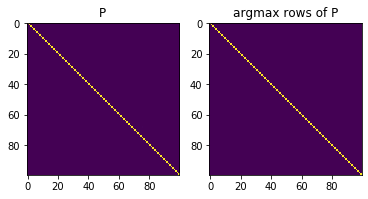

In [13]:
# stable version
# eps=50, w_max_iter need to be large
gw_dist = Entropic_GW(eps=50, max_iter=50, thresh=1e-9, 
                      w_max_iter=10000, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=True, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

Iter: 0 | Err = 0.022135
Break in Gromov-Wasserstein at 9-th iteration: Err = 0.000000
Computed in 0.1757 s
gw_cost: 11291.01940


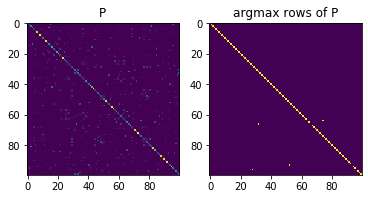

In [14]:
# original version 
# eps = 1e4 (need to be large), w_max_iter = 100 (can be small)
gw_dist = Entropic_GW(eps=1e4, max_iter=100, thresh=1e-9, 
                      w_max_iter=100, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=False, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

### Ex3: Simple translation of a point cloud

In [15]:
# randomly create point clouds x, y
# y is just a translated cloud from x

x = torch.randn((1000, 2)) #* 10
y = x.clone() + 100

#noise = torch.randn(y.shape) * 2

px = torch.ones(x.shape[0])
px /= px.sum()

py = torch.ones(y.shape[0])
py /= py.sum()


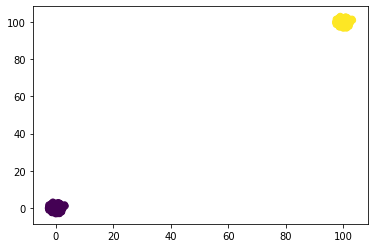

In [16]:
# visualize the points in 2D

points = torch.cat((x,y), dim=0)
colors = torch.cat((torch.zeros(x.shape[0]), torch.ones(y.shape[0])), dim=0)

plt.scatter(points[:,0], points[:, 1], c=colors)

In [17]:
x = x.double().to(device)
y = y.double().to(device)
px = px.double().to(device)
py = py.double().to(device)

Iter: 0 | Err = 0.004594
Break in Gromov-Wasserstein at 10-th iteration: Err = 0.000000
Computed in 10.6978 s
gw_cost: 0.11940


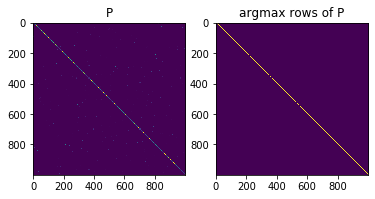

In [18]:
# stable version
# eps = 0.1 (small), w_max_iter = 1000 (large)
gw_dist = Entropic_GW(eps=0.1, max_iter=50, thresh=1e-9, 
                      w_max_iter=1000, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=True, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

Iter: 0 | Err = 0.002618
Iter: 10 | Err = 0.000006
Iter: 20 | Err = 0.000000
Iter: 30 | Err = 0.000000
Break in Gromov-Wasserstein at 31-th iteration: Err = 0.000000
Computed in 1.4220 s
gw_cost: 1.75271


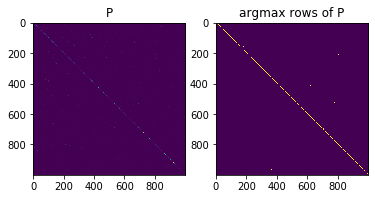

In [19]:
# unstable
# eps = 1 (large), w_max_iter = 100 (small)
gw_dist = Entropic_GW(eps=1, max_iter=50, thresh=1e-9, 
                      w_max_iter=100, w_thresh=1e-9,
                      inter_loss_type='square_loss', 
                      stable_sinkhorn=False, verbose=True)

t0 = time()
gw_cost, P = gw_dist(x, y, px, py)
print('Computed in %.4f s' %(time() - t0))
print('gw_cost: %.5f' %(gw_cost))

show_P(P.to('cpu'))

Comparing with gromov.entropic_gromov_wasserstein of POT library

In [20]:
import ot

In [21]:
def cost_matrix(x, y):
    x_row = x.unsqueeze(-2)
    y_col = y.unsqueeze(-3)
    
    return torch.sum((x_row - y_col) ** 2, dim=-1)

Cx = cost_matrix(x, x)
Cy = cost_matrix(y, y)

POT has to use 'cpu' -> much slower

It.  |Err         
-------------------
    0|2.556238e-03|
   10|1.904903e-08|
   20|2.397761e-10|
compute in 26.43 s


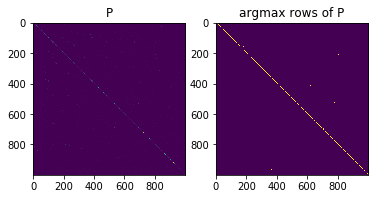

In [22]:
t0 = time()
P = ot.gromov.entropic_gromov_wasserstein(Cx.to('cpu'), Cy.to('cpu'), px.to('cpu'), py.to('cpu'), loss_fun='square_loss', 
    epsilon=1., max_iter=50, tol=1e-9, verbose=True)
print('compute in %.2f s' %(time() - t0))

show_P(torch.from_numpy(P))